# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from collections import defaultdict
from IPython.display import display
from tqdm import tqdm
import matplotlib.pyplot as plt
import mythinkstats as mts
import numpy as np
import pandas as pd
import random
print('Ready')

Ready


## Survival analysis

If we have an unbiased sample of complete lifetimes, we can compute the survival function from the CDF and the hazard function from the survival function.

Here's the distribution of pregnancy length in the NSFG dataset.

In [2]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
complete = preg.query('outcome in [1, 3, 4]').prglngth
complete_pmf = complete.value_counts(normalize=True)
complete_cdf = mts.pmf_to_cdf(complete_pmf)

The survival function is just the complementary CDF.

In [3]:
# Just do 1 - cdf.

In [4]:
complete_srv = 1 - complete_cdf
complete_cdf[13], complete_srv[13]

(0.1397801412101171, 0.8602198587898829)

Here's the CDF and SF.

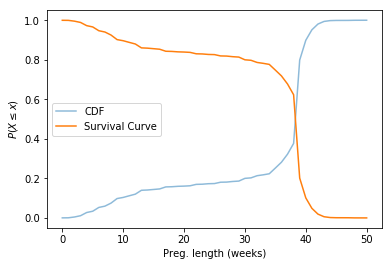

In [5]:
plt.plot(complete_cdf.index, complete_cdf.values, alpha=0.5, label='CDF')
plt.plot(complete_srv.index, complete_srv.values, label='Survival Curve')
plt.xlabel('Preg. length (weeks)')
plt.ylabel('$P(X \leq x)$')
plt.legend()
plt.show()

And here's the hazard function.

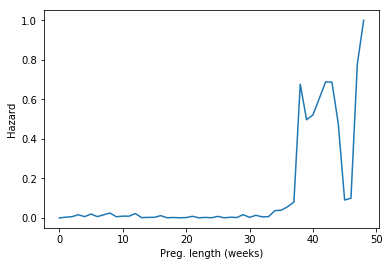

In [6]:
# Hazard function maps from weeks to the proportion of (remaining) pregnancies that ended at that week.
# In other words, hazard expresses the proportion of the population that you lose at each time step.
complete_haz = mts.ccdf_to_hazard(complete_srv)
plt.plot(complete_haz.index, complete_haz.values)
plt.xlabel('Preg. length (weeks)')
plt.ylabel('Hazard')
plt.show()

## Age at first marriage

We'll use the NSFG respondent file to estimate the hazard function and survival function for age at first marriage.

In [7]:
resp = mts.nsfg_read_data('ThinkStats2/code/2002FemResp.dct', 'ThinkStats2/code/2002FemResp.dat.gz')
resp.head()

,caseid,rscrinf,rdormres,rostscrn,rscreenhisp,rscreenrace,age_a,age_r,cmbirth,agescrn,...,pubassis_i,basewgt,adj_mod_basewgt,finalwgt,secu_r,sest,cmintvw,cmlstyr,screentime,intvlngth
0,2298,1,5,5,1,5.0,27,27,902,27,...,0,3247.916977,5123.759559,5556.717241,2,18,1234,1222,18:26:36,110.492667
1,5012,1,5,1,5,5.0,42,42,718,42,...,0,2335.279149,2846.799490,4744.191350,2,18,1233,1221,16:30:59,64.294000
2,11586,1,5,1,5,5.0,43,43,708,43,...,0,2335.279149,2846.799490,4744.191350,2,18,1234,1222,18:19:09,75.149167
3,6794,5,5,4,1,5.0,15,15,1042,15,...,0,3783.152221,5071.464231,5923.977368,2,18,1234,1222,15:54:43,28.642833
4,616,1,5,4,1,5.0,20,20,991,20,...,0,5341.329968,6437.335772,7229.128072,2,18,1233,1221,14:19:44,69.502667


We have to clean up a few variables.

In [8]:
# Replace invalid values for cmmarhx, the date the respondent was first married.
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

# Make a column for age married by converting other columns.
resp['agemarry'] = ((resp.cmmarrhx - resp.cmbirth) / 12.).round(2)

# Make a column for age interviewed.
resp['ageinterview'] = ((resp.cmintvw - resp.cmbirth) / 12.).round(2)

display(resp[['agemarry', 'ageinterview']].head())
resp.shape

,agemarry,ageinterview
0,NaN,27.67
1,21.33,42.92
2,16.83,43.83
3,NaN,16.00
4,NaN,20.17


(7643, 3089)

And the extract the age at first marriage for people who are married, and the age at time of interview for people who are not.

In [9]:
cmpl = resp[resp.evrmarry==1].agemarry.dropna()
ongo = resp[resp.evrmarry==0].ageinterview.dropna()
cmpl.describe(), ongo.describe()

(count    4089.000000
 mean       23.428968
 std         4.736068
 min        11.500000
 25%        19.920000
 50%        22.750000
 75%        26.080000
 max        43.830000
 Name: agemarry, dtype: float64, count    3517.000000
 mean       24.913813
 std         7.536540
 min        15.000000
 25%        18.920000
 50%        22.920000
 75%        29.500000
 max        45.000000
 Name: ageinterview, dtype: float64)

The following function uses Kaplan-Meier to estimate the hazard function.

In [10]:
# Implemented mts.kaplan_meier_survival.

Here is the hazard function and corresponding survival function. 

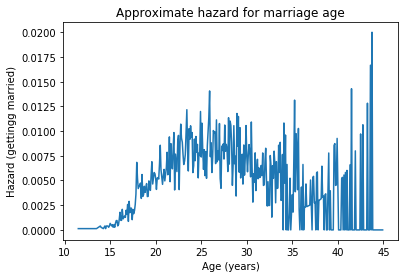

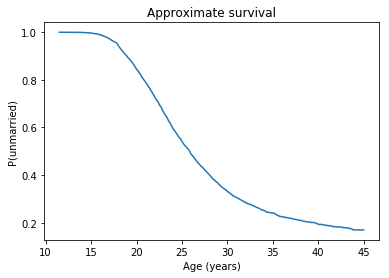

In [11]:
marriage_srv_ccdf = mts.kaplan_meier_survival(cmpl, ongo)
marriage_haz_est = mts.ccdf_to_hazard(marriage_srv_ccdf)
plt.plot(marriage_haz_est.index, marriage_haz_est.values)
plt.title('Approximate hazard for marriage age')
plt.ylabel('Hazard (gettingg married)')
plt.xlabel('Age (years)')
plt.show()

plt.plot(marriage_srv_ccdf.index, marriage_srv_ccdf.values)
plt.title('Approximate survival')
plt.ylabel('P(unmarried)')
plt.xlabel('Age (years)')
plt.show()

## Quantifying uncertainty

To see how much the results depend on random sampling, we'll use a resampling process again.

100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


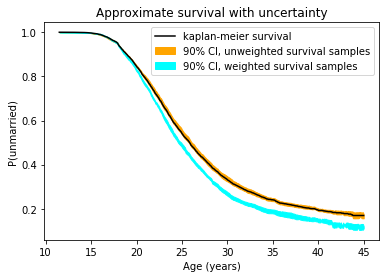

In [12]:
# Resample rows using the 'finalwgt' column to weight the samples.
# Plot the 95% confidence interval from the samples.

# Plot the original survival curve.
cmpl = resp[resp.evrmarry==1].agemarry.dropna()
ongo = resp[resp.evrmarry==0].ageinterview.dropna()
marriage_srv_ccdf = mts.kaplan_meier_survival(cmpl, ongo)
plt.plot(marriage_srv_ccdf.index, marriage_srv_ccdf.values, color='black', label='kaplan-meier survival')

# Re-sample and store the resulting survival probabilities.
iters = 20
age_to_probs = defaultdict(list)
age_to_probs_w = defaultdict(list)

p = resp.finalwgt / resp.finalwgt.sum()
for i in tqdm(range(iters)):
    
    # Alternate taking weighted and unweighted samples.
    if i % 2: 
        sample_indexes = np.random.choice(resp.index.values, len(resp), p=p, replace=True)
        a2p = age_to_probs_w
    else:
        sample_indexes = np.random.choice(resp.index.values, len(resp), replace=True)
        a2p = age_to_probs
        
    resp_ = resp.loc[sample_indexes]
    cmpl = resp_[resp_.evrmarry==1].agemarry.dropna()
    ongo = resp_[resp_.evrmarry==0].ageinterview.dropna()
    srv = mts.kaplan_meier_survival(cmpl, ongo)
    for age, prob in srv.iteritems():
        a2p[age].append(prob)

# Compute and plot CI for unweighted samples.
ages = sorted(age_to_probs.keys())
los, his = [], []
for age in ages:
    probs = age_to_probs[age]
    los.append(np.percentile(probs, 5))
    his.append(np.percentile(probs, 95))
plt.fill_between(ages, los, his, color='orange', label='90% CI, unweighted survival samples')

# Compute and plot CI for weighted samples.
ages = sorted(age_to_probs_w.keys())
los, his = [], []
for age in ages:
    probs = age_to_probs_w[age]
    los.append(np.percentile(probs, 5))
    his.append(np.percentile(probs, 95))
plt.fill_between(ages, los, his, color='cyan', label='90% CI, weighted survival samples')

plt.title('Approximate survival with uncertainty')
plt.ylabel('P(unmarried)')
plt.xlabel('Age (years)')
plt.legend()
plt.show()

The SF based on the raw data falls outside the 90% CI because the CI is based on weighted resampling, and the raw data is not.  You can confirm that by replacing `ResampleRowsWeighted` with `ResampleRows` in `ResampleSurvival`.

## More data

To generate survivial curves for each birth cohort, we need more data, which we can get by combining data from several NSFG cycles.

In [13]:
# Read the data. Got a UnicoDedecodeError for 2010, so skipping it.
cols = ['evrmarry', 'cmmarrhx', 'cmintvw', 'cmbirth', 'finalwgt']
resp95 = mts.nsfg_read_resp_by_year('ThinkStats2/code', 1995)[cols]
resp02 = mts.nsfg_read_resp_by_year('ThinkStats2/code', 2002)[cols]
resp13 = mts.nsfg_read_resp_by_year('ThinkStats2/code', 2013)[cols]

print(resp95.columns.values.tolist())
print(resp02.columns.values.tolist())
print(resp13.columns.values.tolist())
len(resp95) + len(resp02) + len(resp13)

['evrmarry', 'cmmarrhx', 'cmintvw', 'cmbirth', 'finalwgt']
['evrmarry', 'cmmarrhx', 'cmintvw', 'cmbirth', 'finalwgt']
['evrmarry', 'cmmarrhx', 'cmintvw', 'cmbirth', 'finalwgt']


24091

In [14]:
# Combine them to a single dataframe.
resp_cmb = pd.concat([resp95, resp02, resp13], ignore_index=True)
resp_cmb.shape, resp_cmb.index

((24091, 5), RangeIndex(start=0, stop=24091, step=1))

In [15]:
# Replace invalid values for cmmarhx, the date the respondent was first married.
resp_cmb.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

# Make a column for age married by converting other columns.
resp_cmb['agemarry'] = ((resp_cmb.cmmarrhx - resp_cmb.cmbirth) / 12.).round(2)

# Make a column for age interviewed.
resp_cmb['ageinterview'] = ((resp_cmb.cmintvw - resp_cmb.cmbirth) / 12.).round(2)

# Add a column representing the decade of birth.
t0 = pd.to_datetime('1899-12-15')
resp_cmb['decbirth'] = pd.DatetimeIndex(resp_cmb['cmbirth'].apply(lambda x: t0 + pd.DateOffset(months=x))).year
resp_cmb['decbirth'] = resp_cmb['decbirth'] // 10 * 10
resp_cmb['decbirth'].unique()

display(resp_cmb.head())

,evrmarry,cmmarrhx,cmintvw,cmbirth,finalwgt,agemarry,ageinterview,decbirth
0,0,NaN,1149,837,6776.3796,NaN,26.00,1960
1,1,1024.0,1142,781,841.8221,20.25,30.08,1960
2,0,NaN,1145,907,3617.3637,NaN,19.83,1970
3,1,1133.0,1145,771,10788.1271,30.17,31.17,1960
4,0,NaN,1144,927,5359.4150,NaN,18.08,1970


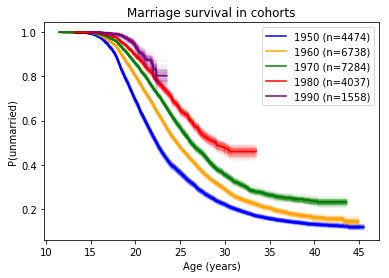

In [16]:
# Approximate and plot survival for each decade.
iters = 100
colors = {1950: 'blue', 1960: 'orange', 1970: 'green', 1980: 'red', 1990: 'purple'}
for decbirth, df in resp_cmb.groupby('decbirth'):
    color = colors[decbirth]
    for i in range(iters):
        df_ = df if i == 0 else df.loc[np.random.choice(df.index, len(df))]
        cmpl = df_[df_.evrmarry==1].agemarry.dropna()
        ongo = df_[df_.evrmarry==0].ageinterview.dropna()
        srv = mts.kaplan_meier_survival(cmpl, ongo)
        label='%s (n=%d)' % (decbirth, len(df)) if i == 0 else None
        alpha = 1 if i == 0 else 5 / iters
        plt.plot(srv.index, srv.values, label=label, alpha=alpha, color=color)
    
plt.title('Marriage survival in cohorts')
plt.ylabel('P(unmarried)')
plt.xlabel('Age (years)')
plt.legend()
plt.show()

The following is the code from `survival.py` that generates SFs broken down by decade of birth.

We can generate predictions by assuming that the hazard function of each generation will be the same as for the previous generation.

In [17]:
# Skipping this because I don't understand 1) what information is gained from this kind of extrapolation,
# 2) why you can assume that one generation is similar enough to the previous to allow such extrapolation?

## Remaining lifetime

Distributions with difference shapes yield different behavior for remaining lifetime as a function of age.

In [18]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
cmpl = preg.query('outcome in [1, 3, 4]').prglngth
ongo = preg[preg.outcome == 6].prglngth
print('Number of complete pregnancies', len(cmpl))
print('Number of ongoing pregnancies', len(ongo))

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


Here's the expected remaining duration of a pregnancy as a function of the number of weeks elapsed.  After week 36, the process becomes "memoryless".

In [19]:
# Testing pmf <-> cdf conversion.
pmf = pd.Series([1,1,1,3,4,5,5,6]).value_counts(normalize=True).sort_index()
cdf = mts.pmf_to_cdf(pmf)
pmf_ = mts.cdf_to_pmf(cdf)
assert np.allclose(pmf.values, pmf_.values)
pmf.values, pmf_.values, pmf_.sum()

(array([0.375, 0.125, 0.125, 0.25 , 0.125]),
 array([0.375, 0.125, 0.125, 0.25 , 0.125]),
 1.0)

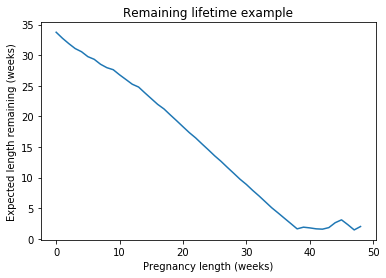

In [20]:
# Compute the pregnancy duration survival and convert it to a PMF.
srv = mts.kaplan_meier_survival(cmpl, ongo)
cdf = 1 - srv
pmf = mts.cdf_to_pmf(cdf).sort_index()

# Use the PMF to compute expected remaining lifetime.
# rem[i] = mean number of weeks expected after week i.
rem = pmf.copy()
for t in pmf.index:
    pmf[t] = 0
    rem[t] = mts.pmf_expectation(pmf / pmf.sum()) - t

plt.title('Remaining lifetime example')
plt.ylabel('Expected length remaining (weeks)')
plt.xlabel('Pregnancy length (weeks)')
plt.plot(rem.index, rem.values)
plt.show()

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [21]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['divorced'] = 1 - resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['duration'] = np.clip(resp.duration, 0, resp.duration.max())
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    # Add a column representing the decade of birth.
    t0 = pd.to_datetime('1899-12-15')
    resp_cmb['decbirth'] = pd.DatetimeIndex(resp_cmb['cmbirth'].apply(lambda x: t0 + pd.DateOffset(months=x))).year
    resp_cmb['decbirth'] = resp_cmb['decbirth'] // 10 * 10
    resp_cmb['decbirth'].unique()
    
cols = ['evrmarry', 'cmmarrhx', 'cmintvw', 'cmbirth', 'cmdivorcx', 'finalwgt']
resp02 = mts.nsfg_read_resp_by_year('ThinkStats2/code', 2002)[cols]
resp13 = mts.nsfg_read_resp_by_year('ThinkStats2/code', 2013)[cols]
resp_cmb = pd.concat([resp02, resp13], ignore_index=True)
CleanData(resp_cmb)
display(resp_cmb.head())
resp_cmb.shape

,evrmarry,cmmarrhx,cmintvw,cmbirth,cmdivorcx,finalwgt,divorced,duration,durationsofar,decbirth
0,0,NaN,1234,902,NaN,5556.717241,0,NaN,NaN,1970
1,1,974.0,1233,718,1077.0,4744.191350,1,8.583333,21.583333,1950
2,1,910.0,1234,708,938.0,4744.191350,1,2.333333,27.000000,1950
3,0,NaN,1234,1042,NaN,5923.977368,0,NaN,NaN,1980
4,0,NaN,1233,991,NaN,7229.128072,0,NaN,NaN,1980


(13244, 10)

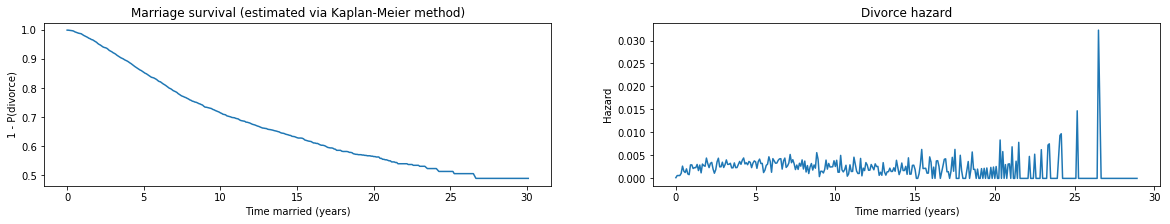

In [22]:
# Compute the duration of marriages that have ended in divorce, and the duration, so far, 
# of marriages that are ongoing.Estimate the hazard and survival curve for the duration of marriage.
cmpl = resp_cmb[resp_cmb.divorced == 1].duration.dropna()
ongo = resp_cmb[resp_cmb.divorced == 0].durationsofar.dropna()

srv = mts.kaplan_meier_survival(cmpl, ongo)
haz = mts.ccdf_to_hazard(srv)

fig, axes = plt.subplots(1, 2, figsize=(20, 3))
fig.axes[0].plot(srv.index, srv.values)
fig.axes[0].set_title('Marriage survival (estimated via Kaplan-Meier method)')
fig.axes[0].set_xlabel('Time married (years)')
fig.axes[0].set_ylabel('1 - P(divorce)')
fig.axes[1].plot(haz.index, haz.values)
fig.axes[1].set_title('Divorce hazard')
fig.axes[1].set_xlabel('Time married (years)')
fig.axes[1].set_ylabel('Hazard')
plt.show()

100%|██████████| 500/500 [00:12<00:00, 39.82it/s]


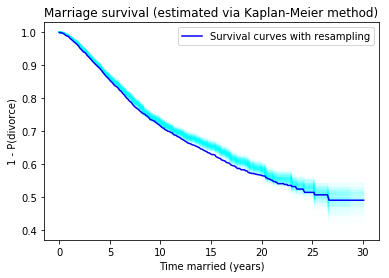

In [23]:
# Use resampling to take into account sampling weights, 
# and plot data from several resamples to visualize sampling error.

iters = 500
p = resp_cmb.finalwgt / resp_cmb.finalwgt.sum()
for i in tqdm(range(iters)):
    
    # Random sample after the first iteration.
    ii = resp_cmb.index if i + 1 == iters else np.random.choice(resp_cmb.index, len(resp_cmb), p=p, replace=True)
    df = resp_cmb.loc[ii]
    
    # Estimate the survival.
    cmpl = df[df.divorced == 1].duration.dropna()
    ongo = df[df.divorced == 0].durationsofar.dropna()
    srv = mts.kaplan_meier_survival(cmpl, ongo)
    haz = mts.ccdf_to_hazard(srv)

    # Plot. Some transparency for the random samples.
    alpha = 1 if i + 1 == iters else 5 / iters
    label = 'Survival curves with resampling' if i + 1 == iters else None
    color = 'blue' if i + 1 == iters else 'cyan'
    plt.plot(srv.index, srv.values, alpha=alpha, color=color, label=label)

plt.title('Marriage survival (estimated via Kaplan-Meier method)')
plt.xlabel('Time married (years)')
plt.ylabel('1 - P(divorce)')
plt.legend()
plt.show()

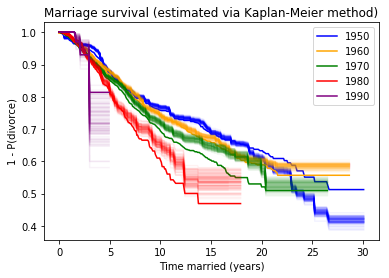

In [24]:
# Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.
# Using decade of birth -- not sure how to access age at first marriage.
iters = 100
colors = {1950: 'blue', 1960: 'orange', 1970: 'green', 1980: 'red', 1990: 'purple'}
for decbirth, df in resp_cmb.groupby('decbirth'):

    color = colors[decbirth]
    p = df.finalwgt / df.finalwgt.sum()
    
    for i in range(iters):

        # Random sample after the first iteration.
        ii = df.index if i + 1 == iters else np.random.choice(df.index, len(resp_cmb), p=p, replace=True)
        df_ = df.loc[ii]

        # Estimate the survival.
        cmpl = df_[df_.divorced == 1].duration.dropna()
        ongo = df_[df_.divorced == 0].durationsofar.dropna()
        srv = mts.kaplan_meier_survival(cmpl, ongo)
        haz = mts.ccdf_to_hazard(srv)

        # Plot. Some transparency for the random samples.
        alpha = 1 if i + 1 == iters else 5 / iters
        label = decbirth if i + 1 == iters else None
        
        plt.plot(srv.index, srv.values, alpha=alpha, color=color, label=label)

plt.title('Marriage survival (estimated via Kaplan-Meier method)')
plt.xlabel('Time married (years)')
plt.ylabel('1 - P(divorce)')
plt.legend()
plt.show()